# LoL Churn Predictor [Part 3 - Data Modeling]

**David Skarbrevik - 2018**

In part 2 we cleaned and analyzed our League of Legends data. Now we want to use that data to build a model that completes some sort of churn-like prediction.

<a id="toc"></a>

<br>
<hr style="background-color: black; padding: 1px;">
<br>

<h2>Table of Contents</h2>

<br>

<ol>
    <h3><li><a href="#section1">Planning</a></li></h3>
    <br>
    <h3><li><a href="#section2">Prepparing the data for modeling</a></li></h3>
    <br>
    <h3><li><a href="#section3">Modeling the data</a></li></h3>
</ol>

<br>
<hr style="background-color: black; padding: 1px;">
<br>

<a id='section1'></a>

## Step 1) Planning

### What preprocessing steps maybe necessary before fitting data to a model?

**There are four things we may need/want to do before training our models:**

**1)** OHE encode categorical and binary features

**2) [optional]** normalize values (many columns have large values)

**3)** create a "label" feature that we will predict on

**4)** remove unwanted features from the dataset


### What prediction tasks to model?

Some possibilities:

* Will the summoner get to level 3 or higher within the first month of play?
* Did the summoner play more than 1 match?
* Did the summoner play at least X matches?



### What types of models to try?

I will start with logistic regression as it seems most fitting for the prediction tasks above, however I will also try some other common models such as random forests. Finally I'll try a simple neural network model if I have time.

***

<div align="right">
    <a href="#toc">back to top</a>
</div>
<a id='section2'></a>

## Step 2) Prepping the data for modeling

This is similar to "cleaning" phase in last notebook, but all changes to dataset here are for the purposes of ML not general analysis.

In [2]:
import pandas as pd
import numpy as np
from collections import Counter

np.random.seed(1)

**First, read cleaned dataframe from file**

In [7]:
df = pd.read_csv("./data/cleaned_riot_data.csv", encoding="ISO-8859-1")

**1) OHE encoding for categorical features**

In [8]:
[(feature, Counter(df[feature].head(n=3))) for feature in list(df)] # which features are categorical?

[('summoner_id', Counter({92201075: 1, 93650017: 1, 92729877: 1})),
 ('summoner_name', Counter({'TrEx18': 1, 'iMain N01': 1, 'luexolu99': 1})),
 ('summoner_level', Counter({5: 3})),
 ('total_matches', Counter({7: 1, 6: 1, 4: 1})),
 ('first_match_time',
  Counter({'2018-01-16T05:50:54.986000+00:00': 1,
           '2018-03-10T06:24:33.477000+00:00': 1,
           '2018-03-10T06:56:11.750000+00:00': 1})),
 ('first_match_duration',
  Counter({'0 days 00:14:00.000000000': 1,
           '0 days 00:16:41.000000000': 1,
           '0 days 00:22:54.000000000': 1})),
 ('first_match_id', Counter({2695060245: 1, 2736710108: 1, 2736716714: 1})),
 ('assists', Counter({16.0: 1, 4.0: 1, 10.0: 1})),
 ('champLevel', Counter({12.0: 1, 11.0: 1, 13.0: 1})),
 ('combatPlayerScore', Counter({0.0: 3})),
 ('creepsPerMinDeltas_0-10', Counter({5.1: 1, 3.5: 1, 0.8: 1})),
 ('creepsPerMinDeltas_10-20', Counter({0.0: 2, 3.6: 1})),
 ('creepsPerMinDeltas_20-30', Counter({0.0: 3})),
 ('creepsPerMinDeltas_30-end', Counte

Looks like just the 'lane' and 'role' features are categorical so let's OHE those. 

Note also, there are a couple True/False columns. Python and python libraries usually treats them as 1/0 already but we'll explicitly change them just in case it causes trouble later.

In [9]:
dummy_lane = pd.get_dummies(df['lane'])
dummy_role = pd.get_dummies(df['role'])

dummy_role.columns.values[3] = "NO_ROLE"
dummy_lane.columns.values[3] = "NO_LANE"

In [10]:
dummy_lane.head()

,BOTTOM,JUNGLE,MIDDLE,NO_LANE,TOP
0,0,0,1,0,0
1,0,0,0,1,0
2,0,1,0,0,0
3,0,0,0,0,1
4,0,1,0,0,0


In [11]:
dummy_role.head()

,DUO,DUO_CARRY,DUO_SUPPORT,NO_ROLE,SOLO
0,0,0,0,0,1
1,0,0,1,0,0
2,0,0,0,1,0
3,0,0,1,0,0
4,0,0,0,1,0


In [12]:
df = df.drop(['lane', 'role'], axis=1)
df = df.join([dummy_role,dummy_lane])

In [13]:
boolean_features = ['firstBloodAssist', 'firstBloodKill', 'firstInhibitorAssist', 
                    'firstInhibitorKill', 'firstTowerAssist', 'firstTowerKill', 'win']

df[boolean_features] = df[boolean_features].astype(int)

Let's just make sure all our features are numeric now:

In [14]:
df.head()

,summoner_id,summoner_name,summoner_level,total_matches,first_match_time,first_match_duration,first_match_id,assists,champLevel,combatPlayerScore,...,DUO,DUO_CARRY,DUO_SUPPORT,NO_ROLE,SOLO,BOTTOM,JUNGLE,MIDDLE,NO_LANE,TOP
0,92201075,TrEx18,5,7,2018-01-16T05:50:54.986000+00:00,0 days 00:14:00.000000000,2695060245,16.0,12.0,0.0,...,0,0,0,0,1,0,0,1,0,0
1,93650017,iMain N01,5,6,2018-03-10T06:24:33.477000+00:00,0 days 00:16:41.000000000,2736710108,4.0,11.0,0.0,...,0,0,1,0,0,0,0,0,1,0
2,92729877,luexolu99,5,4,2018-03-10T06:56:11.750000+00:00,0 days 00:22:54.000000000,2736716714,10.0,13.0,0.0,...,0,0,0,1,0,0,1,0,0,0
3,93839689,Md95359,1,1,2018-03-09T13:05:59.377000+00:00,0 days 00:28:54.000000000,2736217337,0.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,1
4,93599676,lwvvs,5,6,2018-03-09T11:42:58.309000+00:00,0 days 00:30:05.000000000,2736195812,7.0,17.0,0.0,...,0,0,0,1,0,0,1,0,0,0


Looks good, let's move on.

**2) Normalize feature values**

In [15]:
# skipping this step for now

**3) Create a prediction task label feature**

We are trying to predict, from a player's first match stats, if they will play enough to reach summoner level 3 or greater. 

Let's see what the summoner level breakdown for players is in this dataset.

In [16]:
level_counts = Counter(df['summoner_level'])
level_counts

Counter({5: 453, 1: 192, 4: 377, 3: 279, 2: 194})

We see a good amount of each summoner level 1-5. Let's make prediction labels where `level < 3` gets `0` and `level >= 3` gets `1`.

In [17]:
level_data = df['summoner_level'].tolist()
labels = []

for value in level_data:
    if value < 3:
        labels.append(0)
    else:
        labels.append(1)

In [18]:
Counter(labels)

Counter({1: 1109, 0: 386})

While there may not be as many players under level 3 as we'd like, there are still over 300 examples in this group, so this may be a reasonable dataset to prototype the viability of our prediction task.

**4) Removing unwanted features**

Some features like "summoner_name" aren't relevant to training our model and others like "total_matches" and "summoner_level" give the model information we don't want it to have access to.

In [19]:
list(df)

['summoner_id',
 'summoner_name',
 'summoner_level',
 'total_matches',
 'first_match_time',
 'first_match_duration',
 'first_match_id',
 'assists',
 'champLevel',
 'combatPlayerScore',
 'creepsPerMinDeltas_0-10',
 'creepsPerMinDeltas_10-20',
 'creepsPerMinDeltas_20-30',
 'creepsPerMinDeltas_30-end',
 'csDiffPerMinDeltas_0-10',
 'csDiffPerMinDeltas_10-20',
 'csDiffPerMinDeltas_20-30',
 'csDiffPerMinDeltas_30-end',
 'damageDealtToObjectives',
 'damageDealtToTurrets',
 'damageSelfMitigated',
 'damageTakenDiffPerMinDeltas_0-10',
 'damageTakenDiffPerMinDeltas_10-20',
 'damageTakenDiffPerMinDeltas_20-30',
 'damageTakenDiffPerMinDeltas_30-end',
 'damageTakenPerMinDeltas_0-10',
 'damageTakenPerMinDeltas_10-20',
 'damageTakenPerMinDeltas_20-30',
 'damageTakenPerMinDeltas_30-end',
 'deaths',
 'doubleKills',
 'firstBloodAssist',
 'firstBloodKill',
 'firstInhibitorAssist',
 'firstInhibitorKill',
 'firstTowerAssist',
 'firstTowerKill',
 'goldEarned',
 'goldPerMinDeltas_0-10',
 'goldPerMinDeltas_10-

In [20]:
extra_features = ['summoner_id', 'summoner_level', 'summoner_name', 'id', 'first_match_time',
                  'first_match_id', 'first_match_duration', 'latest_match_time', 'total_matches']

num_full_features = df.shape[1]

df = df.drop(extra_features, axis=1)

num_training_features = df.shape[1]

print("Number of features in full dataset: {}".format(num_full_features))
print("Number of features in model training dataset: {}".format(num_training_features))

Number of features in full dataset: 124
Number of features in model training dataset: 115


**Lastly let's save the ML ready dataset and prediction labels for future use**

In [25]:
df.to_csv("./data/riot_cleaned_ml_data.csv", index=False) # dataset
pd.DataFrame(labels).to_csv("./data/ml_data_labels.csv", index=False) # labels

**Great! We're finally ready to fit our data to some models!**

***

<div align="right">
    <a href="#toc">back to top</a>
</div>
<a id='section3'></a>

## Step 3) Modeling the data

In [4]:
# import libraries 

import pandas as pd
import numpy as np
from collections import Counter

np.random.seed(1)

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score


import tensorflow as tf

import math
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [5]:
# import ML ready data
df = pd.read_csv("./data/riot_cleaned_ml_data.csv", encoding="ISO-8859-1")
labels = pd.read_csv("./data/ml_data_labels.csv", encoding="ISO-8859-1")

In [6]:
# convert to np arrays
X = np.array(df)
Y = np.array(labels)

**Randomize and split data into train/test sets**

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=0.85, test_size=0.15, random_state=2)

print("Training examples: {}".format(X_train.shape[0]))
print("Training labels: {}".format(Y_train.shape[0]))
print("Test examples: {}".format(X_test.shape[0]))
print("Test labels: {}".format(Y_test.shape[0]))

Training examples: 1270
Training labels: 1270
Test examples: 225
Test labels: 225


Before we fit our data to the prediction task we created, let's take a moment to run principal component analysis to see if there are any features of particularly high explanatory variance.

### Principal Component Analysis

Text(0.5,1,'PCA: Explained Variance in first 10 components')

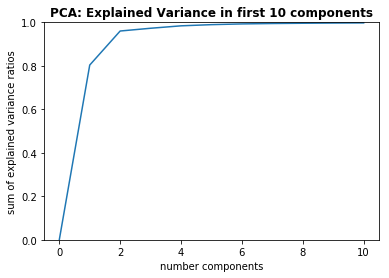

In [120]:
# project data across N-dimensions
n_comp = 10
pca_mod = PCA(n_components = n_comp)
pca_mod.fit(X_train)

# cummulative ratio of explained variance
varRatio = pca_mod.explained_variance_ratio_
sumVarRatio = np.cumsum(np.concatenate(([0], varRatio)))

# plot the data to visualize
plt.plot(range(n_comp+1),sumVarRatio)
plt.xlabel('number components')
plt.ylabel('sum of explained variance ratios')
plt.ylim([0,1])
plt.title("PCA: Explained Variance in first 10 components", 
          fontsize=12, fontweight="bold")

A lot of variance can be summarized in the first two components, let's see which features are contributing the most to these two components:

In [124]:
most_variance = []

# top three components
for variance in pca_mod.components_[:3]:
    
    variance_components = zip(list(df),np.abs(variance))
    sorted_variance = list(reversed(sorted(variance_components, key=lambda tup: tup[1])))

    most_variance.append(sorted_variance)

In [132]:
for i in range(len(most_variance)):
    print("Top features in component {}".format(i+1))
    print("-"*40)
    for name,value in most_variance[0][:10]:
        print("{0} = {1:.2f}%".format(name,(value*100)))
    print("\n")

Top features in component 1
----------------------------------------
totalDamageDealt = 73.54%
physicalDamageDealt = 58.61%
totalDamageDealtToChampions = 20.61%
physicalDamageDealtToChampions = 15.43%
magicDamageDealt = 12.39%
totalDamageTaken = 9.74%
damageSelfMitigated = 7.90%
goldSpent = 5.88%
physicalDamageTaken = 5.70%
damageDealtToObjectives = 5.29%


Top features in component 2
----------------------------------------
totalDamageDealt = 73.54%
physicalDamageDealt = 58.61%
totalDamageDealtToChampions = 20.61%
physicalDamageDealtToChampions = 15.43%
magicDamageDealt = 12.39%
totalDamageTaken = 9.74%
damageSelfMitigated = 7.90%
goldSpent = 5.88%
physicalDamageTaken = 5.70%
damageDealtToObjectives = 5.29%


Top features in component 3
----------------------------------------
totalDamageDealt = 73.54%
physicalDamageDealt = 58.61%
totalDamageDealtToChampions = 20.61%
physicalDamageDealtToChampions = 15.43%
magicDamageDealt = 12.39%
totalDamageTaken = 9.74%
damageSelfMitigated = 7.90%


We see that features describing damage dealt have very high explantory power in this dataset. This was an expected result but it's surprising just how overwhelming all those features are. We see "gold spent" ranking highly as well. This was not explored during EDA, but it is worth considering the subtlety that while it is intuitive to think a new player that is catching on to the game faster would have higher "gold earned", they would also be picking up on the game mechanic of spending that gold. In League of Legends there it is not shoved in your face or forced in any way that you spend your gold so it takes a player actually exploring the game's features to spend gold.

This PCA data may be useful to us in the future, but for now let's move on with our dataset as it stands now and try to fit a model to our prediction task (yup! no more detours, we're _finally_ there! :D ).

### Logistic Regression Model

In [20]:
log_model = LogisticRegression()
log_model.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [21]:
logistic_accuracy = log_model.score(X_test, Y_test)
preds = log_model.predict(X_test)
log_f1 = f1_score(Y_test, preds)
print("Accuracy of logistic regression model on test data: {:.2f}%".format(logistic_accuracy*100))
print("F1-score for logistic regression model on test data: {:.2f}".format(log_f1))

Accuracy of logistic regression model on test data: 74.25%
F1-score for logistic regression model on test data: 0.84


**Not bad at all!**

There are a lot of qualifiers we should point out about this result before we jump for joy, but 74% accuracy on this relatively small dataset with just a vanilla, out of the box, logistic regression model is very encouraging.

Next, let's try some other out of the box models.

### Decision Tree Model

In [22]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [23]:
tree_accuracy = tree_model.score(X_test, Y_test)
preds = tree_model.predict(X_test)
tree_f1 = f1_score(Y_test, preds)
print("Accuracy of ada boosted model on test data: {:.2f}%".format(tree_accuracy*100))
print("F1-score for ada boosted model on test data: {:.2f}".format(tree_f1))

Accuracy of ada boosted model on test data: 64.21%
F1-score for ada boosted model on test data: 0.76


### Random Forest Model

In [24]:
forest_model = RandomForestClassifier()
forest_model.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
forest_accuracy = forest_model.score(X_test, Y_test)
preds = forest_model.predict(X_test)
forest_f1 = f1_score(Y_test, preds)
print("Accuracy of ada boosted model on test data: {:.2f}%".format(forest_accuracy*100))
print("F1-score for ada boosted model on test data: {:.2f}".format(forest_f1))

Accuracy of ada boosted model on test data: 70.90%
F1-score for ada boosted model on test data: 0.82


### Gradient Boosting Model

In [26]:
gradient_model = GradientBoostingClassifier()
gradient_model.fit(X_train, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [27]:
gradient_accuracy = gradient_model.score(X_test, Y_test)
preds = gradient_model.predict(X_test)
gradient_f1 = f1_score(Y_test, preds)
print("Accuracy of ada boosted model on test data: {:.2f}%".format(gradient_accuracy*100))
print("F1-score for ada boosted model on test data: {:.2f}".format(gradient_f1))

Accuracy of ada boosted model on test data: 73.91%
F1-score for ada boosted model on test data: 0.84


### Ada Boosting Model

In [28]:
ada_model = AdaBoostClassifier()
ada_model.fit(X_train, Y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [29]:
ada_accuracy = ada_model.score(X_test, Y_test)
preds = ada_model.predict(X_test)
ada_f1 = f1_score(Y_test, preds)
print("Accuracy of ada boosted model on test data: {:.2f}%".format(ada_accuracy*100))
print("F1-score for ada boosted model on test data: {:.2f}".format(ada_f1))

Accuracy of ada boosted model on test data: 70.90%
F1-score for ada boosted model on test data: 0.81


<h3>Summary of Basic Models</h3>

<br>

<table align="left" style="width:30%">
    <tr>
        <th>Model Type</th>
        <th>Accuracy</th>
        <th>F1-Score</th>
    </tr>
    <tr>
        <td>Logistic Regression</td>
        <td>74.25%</td>
        <td>0.84</td>
    </tr>
    <tr>
        <td>Decision Tree</td>
        <td>62.21%</td>
        <td>0.74</td>
    </tr>
    <tr>
        <td>Random Forest</td>
        <td>70.90%</td>
        <td>0.82</td>
    </tr>
    <tr>
        <td>Gradient Boosting</td>
        <td>73.91%</td>
        <td>0.84</td>
    </tr>
    <tr>
        <td>Ada Boosting</td>
        <td>70.90%</td>
        <td>0.81</td>
    </tr>
</table>

<br>

<p style="padding-left:350px;"> We achieved good results with logistic regression and random forests without any hyperparameter tuning. Because logistic regression worked so well, I'm curious how a small feed-forward neural network will fare on this dataset. </p>

### Neural Network Model

In [8]:
# transpose train/test set to prepare for neural network
X_train_network = X_train.T
X_test_network = X_test.T
Y_train_network = Y_train.reshape(1, Y_train.shape[0])
Y_test_network = Y_test.reshape(1, Y_test.shape[0])

In [9]:
print("Training set shape: {}".format(X_train_network.shape))
print("Training labels shape: {}".format(Y_train_network.shape))
print("\n")
print("Test set shape: {}".format(X_test_network.shape))
print("Test labels shape: {}".format(Y_test_network.shape))

Training set shape: (115, 1270)
Training labels shape: (1, 1270)


Test set shape: (115, 225)
Test labels shape: (1, 225)


In [98]:
def neural_network(X_train_network, Y_train_network, X_test_network, Y_test_network, 
                   num_layers, nodes_in_layer, num_epochs, learning_rate, L2 = False, beta=0.01,
                   optimization="gradient descent", verbose=False):

    # to allow re-running of the network
    ops.reset_default_graph()                         
    
    # make sure all layers are assigned nodes
    assert num_layers == len(nodes_in_layer)

    
    costs = []
    parameters = {}
    activations = {}
     
        
    # step 1) placeholders for data

    X = tf.placeholder(tf.float32, shape=[X_train_network.shape[0], None], name="X_data")
    Y = tf.placeholder(tf.float32, shape=[Y_train_network.shape[0], None], name="Y_data")

    
    # step 2) initialize network parameters

    parameters["W1"] = tf.get_variable("W1", [nodes_in_layer[0],X_train_network.shape[0]], initializer = tf.contrib.layers.xavier_initializer(seed=2))
    parameters["b1"] = tf.get_variable("b1", [nodes_in_layer[0],1], initializer = tf.contrib.layers.xavier_initializer(seed=2))
    
    if verbose:
        print("W1 shape = {}".format(parameters["W1"].get_shape()))
        print("b1 shape = {}".format(parameters["b1"].get_shape()))

    for i in range(1,num_layers):
        parameters["W{}".format(i+1)] = tf.get_variable("W{}".format(i+1), [nodes_in_layer[i],nodes_in_layer[i-1]], 
                                                        initializer = tf.contrib.layers.xavier_initializer(seed=2))
        
        if verbose:
            print("W{0} shape = {1}".format((i+1),parameters["W{}".format(i+1)].get_shape()))
            
        parameters["b{}".format(i+1)] = tf.get_variable("b{}".format(i+1), [nodes_in_layer[i], 1], 
                                                        initializer = tf.contrib.layers.xavier_initializer(seed=2))
        
        if verbose:
            print("b{0} shape = {1}".format((i+1),parameters["b{}".format(i+1)].get_shape()))

        
    # step 3) forward propagation
    
    activations["Z1"] = tf.add(tf.matmul(parameters["W1"], X), parameters["b1"])
    activations["A1"] = tf.nn.tanh(activations["Z1"])
    
    if verbose:
        print("Z1 shape = {}".format(activations["Z1"].get_shape()))
        print("A1 shape = {}".format(activations["A1"].get_shape()))
    
    for i in range(1,num_layers-1):
        activations["Z{}".format(i+1)] = tf.add(tf.matmul(parameters["W{}".format(i+1)],
                                                          activations["A{}".format(i)]), parameters["b{}".format(i+1)])
        
        if verbose:
            print("Z{0} shape = {1}".format((i+1),activations["Z{}".format(i+1)].get_shape()))
        
        activations["A{}".format(i+1)] = tf.nn.tanh(activations["Z{}".format(i+1)])  
        
        if verbose:
            print("A{0} shape = {1}".format((i+1),activations["A{}".format(i+1)].get_shape()))
     
    activations["Z{}".format(num_layers)] = tf.add(tf.matmul(parameters["W{}".format(num_layers)],
                                                             activations["A{}".format(num_layers-1)]), parameters["b{}".format(num_layers)])
    
    if verbose:
        print("Z{0} shape = {1}".format((num_layers),activations["Z{}".format(num_layers)].get_shape()))

    
    # step 4) compute cost & perform backprop
    
    logits = tf.transpose(activations["Z{}".format(num_layers)])
    labels = tf.transpose(Y)
    
    if L2:
        l2_reg = tf.nn.l2_loss(tf.transpose(parameters["W1"]))
        for i in range(1,num_layers):
            l2_reg += tf.nn.l2_loss(tf.transpose(parameters["W{}".format(i+1)]))
    
        cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=labels))
        
        cost = tf.reduce_mean(cost + beta * l2_reg)
        
        if optimization == "gradient descent":
            optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
        elif optimization == "adam":
            optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
        else:
            raise NameError("optimization must be either 'gradient descent' or 'adam'")

    else:        
        cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=labels))
        
        if optimization == "gradient descent":
            optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
        elif optimization == "adam":
            optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
        else:
            raise NameError("optimization must be either 'gradient descent' or 'adam'")
  
    
    # step 5) initialize and run Session
    
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):
    
            _ , epoch_cost = sess.run([optimizer, cost], feed_dict={X: X_train_network, Y: Y_train_network})
                
            # Print the cost every epoch
            if epoch % 1000 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if epoch % 10 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        trained_parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        
        # Calculate the correct predictions        
        correct_prediction = tf.equal(tf.greater(activations["Z{}".format(num_layers)],0.5), tf.cast(Y, tf.bool))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy: {}".format(accuracy.eval({X: X_train_network, Y: Y_train_network})))
        print ("Test Accuracy: {}".format(accuracy.eval({X: X_test_network, Y: Y_test_network})))

        return trained_parameters

Now we're ready to use our neural network model:

Cost after epoch 0: 0.593246
Cost after epoch 100: 0.526663
Cost after epoch 200: 0.525855
Cost after epoch 300: 0.524321
Cost after epoch 400: 0.523534
Cost after epoch 500: 0.522908
Cost after epoch 600: 0.522393
Cost after epoch 700: 0.521955
Cost after epoch 800: 0.521579
Cost after epoch 900: 0.521247


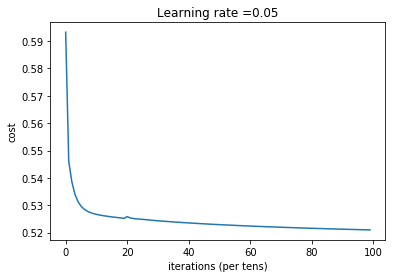

Parameters have been trained!
Train Accuracy: 0.769291341304779
Test Accuracy: 0.7599999904632568


In [90]:
# seed for reproducibility
tf.set_random_seed(2)

# choose your parameters
num_layers = 3
nodes_in_layer = [25,12,1]
num_epochs= 1000
learning_rate = 0.05

# train and test the network
test = neural_network(X_train_network, Y_train_network, X_test_network, Y_test_network, 
               num_layers, nodes_in_layer, num_epochs, learning_rate)

Great! Our neural network seems to be working well. Let's review some hyperparameters we've set for this network and consider how best to tune it.

**Hyperparameters:**

* Learning rate
* Number of epochs
* Number of layers
* Number of nodes per player
* Regularization
* Optimizer algorithm

These are a few things we might play around with to get better accuracy. I'm kind of hungry, so first I'm going to play with the number of epochs (set it all the way up to 1,000,000) while I go get lunch :D

Let's setup a notification so we know when this finishes training:

In [44]:
import jupyternotify # gives desktop notifications when cell blocks complete
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics(ip, require_interaction=True))

<IPython.core.display.Javascript object>

**Increasing number of epochs (to 1 million)**

W1 shape = (25, 115)
b1 shape = (25, 1)
W2 shape = (12, 25)
b2 shape = (12, 1)
W3 shape = (1, 12)
b3 shape = (1, 1)
Z1 shape = (25, ?)
A1 shape = (25, ?)
Z2 shape = (12, ?)
A2 shape = (12, ?)
Z3 shape = (1, ?)
Cost after epoch 0: 0.593246
Cost after epoch 10000: 0.511948
Cost after epoch 20000: 0.498437
Cost after epoch 30000: 0.492476
Cost after epoch 40000: 0.489381
Cost after epoch 50000: 0.487745
Cost after epoch 60000: 0.486808
Cost after epoch 70000: 0.486282
Cost after epoch 80000: 0.485969
Cost after epoch 90000: 0.485765
Cost after epoch 100000: 0.485624
Cost after epoch 110000: 0.485521
Cost after epoch 120000: 0.485443
Cost after epoch 130000: 0.485381
Cost after epoch 140000: 0.485332
Cost after epoch 150000: 0.485292
Cost after epoch 160000: 0.485258
Cost after epoch 170000: 0.485230
Cost after epoch 180000: 0.485206
Cost after epoch 190000: 0.485186
Cost after epoch 200000: 0.485168
Cost after epoch 210000: 0.485152
Cost after epoch 220000: 0.485172
Cost after epoch 23000

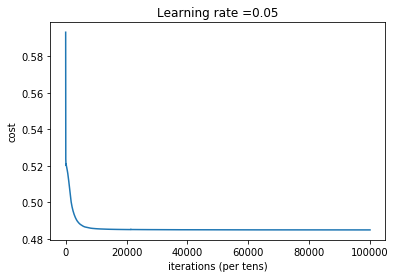

Parameters have been trained!
Train Accuracy: 0.78503937
Test Accuracy: 0.7511111
Wall time: 49min 31s


<IPython.core.display.Javascript object>

In [45]:
%%notify -m "1 million epoch training complete!"
%%time

# seed for reproducibility
tf.set_random_seed(2)

# choose your parameters
num_layers = 3
nodes_in_layer = [25,12,1]
num_epochs= 1000000
learning_rate = 0.05

# train and test the network
test = neural_network(X_train_network, Y_train_network, X_test_network, Y_test_network, 
               num_layers, nodes_in_layer, num_epochs, learning_rate)

It looks like the cost was coming to a minimum at around 20,000 epochs. Training for 1 million just caused us to overfit the data.

**Next let's try increasing the number and size of layers and rerunning with 20,000 epochs!**

W1 shape = (75, 115)
b1 shape = (75, 1)
W2 shape = (50, 75)
b2 shape = (50, 1)
W3 shape = (50, 50)
b3 shape = (50, 1)
W4 shape = (25, 50)
b4 shape = (25, 1)
W5 shape = (12, 25)
b5 shape = (12, 1)
W6 shape = (1, 12)
b6 shape = (1, 1)
Z1 shape = (75, ?)
A1 shape = (75, ?)
Z2 shape = (50, ?)
A2 shape = (50, ?)
Z3 shape = (50, ?)
A3 shape = (50, ?)
Z4 shape = (25, ?)
A4 shape = (25, ?)
Z5 shape = (12, ?)
A5 shape = (12, ?)
Z6 shape = (1, ?)
Cost after epoch 0: 0.577163
Cost after epoch 100: 0.528031
Cost after epoch 200: 0.524358
Cost after epoch 300: 0.521026
Cost after epoch 400: 0.518838
Cost after epoch 500: 0.517749
Cost after epoch 600: 0.515660
Cost after epoch 700: 0.513785
Cost after epoch 800: 0.513308
Cost after epoch 900: 0.510518
Cost after epoch 1000: 0.507958
Cost after epoch 1100: 0.505336
Cost after epoch 1200: 0.503134
Cost after epoch 1300: 0.501649
Cost after epoch 1400: 0.498434
Cost after epoch 1500: 0.496939
Cost after epoch 1600: 0.500093
Cost after epoch 1700: 0.49

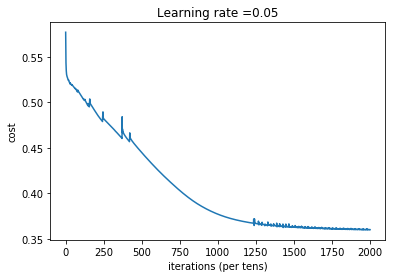

Parameters have been trained!
Train Accuracy: 0.82755905
Test Accuracy: 0.74666667
Wall time: 2min 46s


<IPython.core.display.Javascript object>

In [48]:
%%notify -m "6 layer neural network training complete!"
%%time

# seed for reproducibility
tf.set_random_seed(2)

# choose your parameters
num_layers = 6
nodes_in_layer = [75,50,50,25,12,1]
num_epochs= 20000
learning_rate = 0.05

# train and test the network
test = neural_network(X_train_network, Y_train_network, X_test_network, Y_test_network, 
               num_layers, nodes_in_layer, num_epochs, learning_rate)

Hmm ok so with more layers and nodes we're seeing higher training accuracy but lower test accuracy. Let's try adding **L2 regularization** into the mix.

W1 shape = (75, 115)
b1 shape = (75, 1)
Z1 shape = (75, ?)
A1 shape = (75, ?)
Cost after epoch 0: 1.834868
Cost after epoch 1000: 0.991425
Cost after epoch 2000: 0.706543
Cost after epoch 3000: 0.602721
Cost after epoch 4000: 0.568588
Cost after epoch 5000: 0.558666
Cost after epoch 6000: 0.564629
Cost after epoch 7000: 0.557384
Cost after epoch 8000: 0.561389
Cost after epoch 9000: 0.556294
Cost after epoch 10000: 0.559462
Cost after epoch 11000: 0.552639
Cost after epoch 12000: 0.548497
Cost after epoch 13000: 0.572425
Cost after epoch 14000: 0.578250
Cost after epoch 15000: 0.579544
Cost after epoch 16000: 0.587152
Cost after epoch 17000: 0.579927
Cost after epoch 18000: 0.576593
Cost after epoch 19000: 0.573586


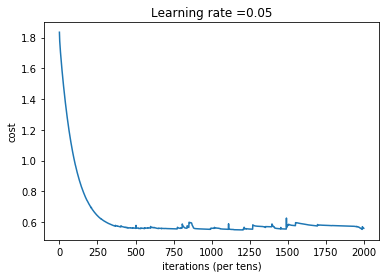

Parameters have been trained!
Train Accuracy: 0.7622047
Test Accuracy: 0.7688889
Wall time: 2min 44s


<IPython.core.display.Javascript object>

In [55]:
%%notify -m "6 layer neural network (with l2 loss) training complete!"
%%time

# seed for reproducibility
tf.set_random_seed(2)

# choose your parameters
num_layers = 6
nodes_in_layer = [75,50,50,25,12,1]
num_epochs= 20000
learning_rate = 0.01

# train and test the network
test = neural_network(X_train_network, Y_train_network, X_test_network, Y_test_network, 
               num_layers, nodes_in_layer, num_epochs, learning_rate, L2 = True)

L2 loss has helped us get a similar accuracy between train and test sets but we aren't really seeing much improvement and our cost is just fluctuating after a couple hundred epochs. **Let's try lowering the learning rate considerably.** Because we're lowering the alpha considerably, we're also going to increase the number of epochs.

Cost after epoch 0: 1.834868
Cost after epoch 2000: 1.743892
Cost after epoch 4000: 1.690653
Cost after epoch 6000: 1.642418
Cost after epoch 8000: 1.597107
Cost after epoch 10000: 1.553827
Cost after epoch 12000: 1.512265
Cost after epoch 14000: 1.473534
Cost after epoch 16000: 1.436089
Cost after epoch 18000: 1.400683
Cost after epoch 20000: 1.366131
Cost after epoch 22000: 1.333043
Cost after epoch 24000: 1.301143
Cost after epoch 26000: 1.270533
Cost after epoch 28000: 1.241383
Cost after epoch 30000: 1.213429
Cost after epoch 32000: 1.186291
Cost after epoch 34000: 1.160371
Cost after epoch 36000: 1.135412
Cost after epoch 38000: 1.111436
Cost after epoch 40000: 1.088581
Cost after epoch 42000: 1.066564
Cost after epoch 44000: 1.045667
Cost after epoch 46000: 1.025677
Cost after epoch 48000: 1.005784
Cost after epoch 50000: 0.987193
Cost after epoch 52000: 0.968783
Cost after epoch 54000: 0.952954
Cost after epoch 56000: 0.936299
Cost after epoch 58000: 0.920072
Cost after epoch 6

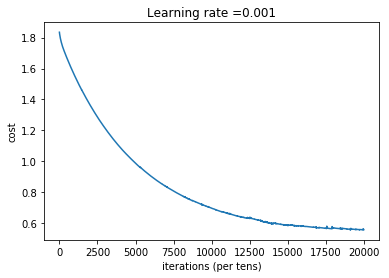

Parameters have been trained!
Train Accuracy: 0.7818897366523743
Test Accuracy: 0.7733333110809326
Wall time: 27min 56s


<IPython.core.display.Javascript object>

In [92]:
%%notify -m "Neural network training complete!"
%%time

# seed for reproducibility
tf.set_random_seed(2)

# choose your parameters
num_layers = 6
nodes_in_layer = [75,50,50,25,12,1]
num_epochs= 200000
learning_rate = 0.001
L2_regularization = True

# train and test the network
test = neural_network(X_train_network, Y_train_network, X_test_network, Y_test_network, 
               num_layers, nodes_in_layer, num_epochs, learning_rate, L2 = L2_regularization)

A modest 2% improvement. We could decrease the learning rate a little more and add significantly more epochs. Maybe also change the optimizer to something else like Adam. But let's settle for this accuracy for now.

Instead we'll switch our efforts toward getting more data. In the first Jupyter notebook ("Data Collection") you'll see a new round of data collection (round 9) toward the very bottom of the notebook.

But in the mean time, while we're waiting for more data to come in, let's kick off training on a model that has all the things mentioned above (Adam, lower learning rate, more epochs).

Cost after epoch 0: 1.834868
Cost after epoch 1000: 0.854436
Cost after epoch 2000: 0.589941
Cost after epoch 3000: 0.496442
Cost after epoch 4000: 0.469640
Cost after epoch 5000: 0.451398
Cost after epoch 6000: 0.430705
Cost after epoch 7000: 0.434580
Cost after epoch 8000: 0.420118
Cost after epoch 9000: 0.423941


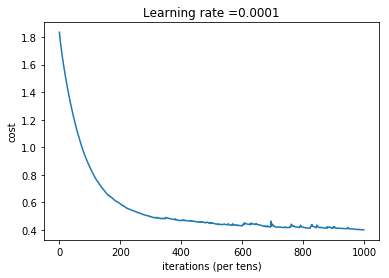

Parameters have been trained!
Train Accuracy: 0.9078739881515503
Test Accuracy: 0.6622222065925598
Wall time: 1min 24s


<IPython.core.display.Javascript object>

In [100]:
%%notify -m "Neural network training complete!"
%%time

# seed for reproducibility
tf.set_random_seed(2)

# choose your parameters
num_layers = 6
nodes_in_layer = [75,50,50,25,12,1]
num_epochs= 10000
learning_rate = 0.0001
L2_regularization = True
optimizer = "adam"

# train and test the network
test = neural_network(X_train_network, Y_train_network, X_test_network, Y_test_network, 
               num_layers, nodes_in_layer, num_epochs, learning_rate, L2 = L2_regularization, optimization = optimizer)

***

<div align="right">
    <a href="#toc">back to top</a>
</div>

## End of Part 3

## That's it!

We've seen that it is possible to predict (with great accuracy) whether a new League of Legends player will ge through their tutorial matches (reach summoner level 3) or not, based only on the gameplay data of that player's first match!